In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import pandas as pd
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pytorch_lightning as pl

import opf
import opf.utils
import opf.dataset
import utils

# fix issues with figures using underscores in their names
mpl.rcParams["text.usetex"] = False


In [3]:
case_name = "case30"
run_id = "2lllzf30"
data_dir = "../data/"
log_dir = "../logs/"


Unnormalized adjacency matrix
Non-zero edges: 82
Connected components: 1


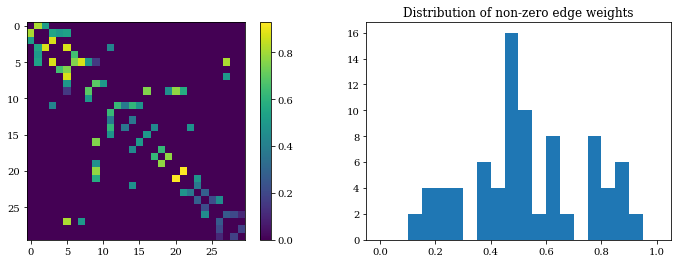

In [4]:
dm = opf.dataset.CaseDataModule("case30", "../data", adj_threshold=0.01)
print("Unnormalized adjacency matrix")
opf.utils.graph_info(dm.gso(normalize=False), plot=True)


In [6]:
api = wandb.Api()
run = api.run(f"damowerko/opf/{run_id}")

save_dir = f"../figures/{run.config['case_name']}/"
os.makedirs(save_dir, exist_ok=True)


def save(title: str, fig=plt):
    fig.savefig(save_dir + f"{title}.png")
    fig.savefig(save_dir + f"{title}.pdf")


barrier = opf.utils.create_model(dm, run.config)
utils.load_checkpoint(barrier, run.id, log_dir)


In [29]:
outputs = utils.test(barrier, trainer, dm)
outputs

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Testing: 100%|██████████| 798/798 [00:14<00:00, 54.67it/s]


/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


,test/cost,test/equality/loss,test/equality/rate,test/equality/error_mean,test/equality/error_max,test/inequality/loss,test/inequality/rate,test/inequality/error_mean,test/inequality/error_max,acopf/cost,acopf/equality/loss,acopf/equality/rate,acopf/equality/error_mean,acopf/equality/error_max,acopf/inequality/loss,acopf/inequality/rate,acopf/inequality/error_mean,acopf/inequality/error_max
0,1.536422,1.391433e-24,0.0,0.0,0.0,0.041016,0.004065,0.016673,0.056086,1.564602,4.945101e-09,0.0,0.0,0.0,0.018953,0.0,0.0,0.0
1,1.288416,8.227845e-25,0.0,0.0,0.0,0.039519,0.004065,0.015550,0.053189,1.367200,4.839745e-09,0.0,0.0,0.0,0.018713,0.0,0.0,0.0
2,1.449328,6.932830e-25,0.0,0.0,0.0,0.035787,0.004065,0.013217,0.045697,1.514406,1.258483e-08,0.0,0.0,0.0,0.017290,0.0,0.0,0.0
3,1.304843,8.052713e-25,0.0,0.0,0.0,0.035594,0.004065,0.012985,0.045386,1.382305,4.855451e-09,0.0,0.0,0.0,0.018269,0.0,0.0,0.0
4,1.326985,9.026853e-25,0.0,0.0,0.0,0.032566,0.004065,0.010884,0.039241,1.412437,3.289524e-09,0.0,0.0,0.0,0.017009,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1.334002,5.090614e-25,0.0,0.0,0.0,0.015973,0.000000,0.000000,0.000000,1.388086,7.451847e-09,0.0,0.0,0.0,0.015263,0.0,0.0,0.0
794,1.282582,4.642794e-25,0.0,0.0,0.0,0.016035,0.000000,0.000000,0.000000,1.335896,6.336603e-09,0.0,0.0,0.0,0.015282,0.0,0.0,0.0
795,1.411407,1.099343e-24,0.0,0.0,0.0,0.028708,0.004065,0.008240,0.030455,1.484057,2.312272e-08,0.0,0.0,0.0,0.016247,0.0,0.0,0.0
796,1.319288,5.706887e-25,0.0,0.0,0.0,0.033273,0.004065,0.011421,0.040770,1.400140,1.878884e-08,0.0,0.0,0.0,0.017080,0.0,0.0,0.0


Bad pipe message: %s [b' x86_64; rv:91.0) Gecko/20100101 Firefox/91.0\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/w']
Bad pipe message: %s [b'p,*/*;q=0.8\r\nAccept-Language: en-US,en;q=0.5\r\nAccept-Encoding: gzip, deflate\r\nConnection: keep-alive']
Bad pipe message: %s [b'Upgrade-Inse']
Bad pipe message: %s [b'(X11; Linux x86_64; rv:91.0) Gecko/20100101 Fir']
Bad pipe message: %s [b'ox/91.0\r\nAccept: image/webp,*/*\r\nAccept-Language: en-US,en;q=0.5\r\nAccept-Encoding: gzip, deflate\r\nCo']
Bad pipe message: %s [b'ection: keep-alive\r\nReferer: http://localhost:43225/\r\nSec-Fetch-Dest: image\r\nSec-Fetch-Mode: no-cors\r\nSec-Fet']


In [6]:
(df[["test/cost","test/inequality/rate"]].mean(),
df[[
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].max())

(test/cost               1.347088
 test/inequality/rate    0.002822
 dtype: float64,
 test/inequality/error_max                             0.092507
 test/inequality/active_power/error_max                0.000000
 test/inequality/reactive_power/error_max              0.000000
 test/inequality/voltage_magnitude/error_max           0.000000
 test/inequality/forward_rate/error_max                0.092507
 test/inequality/backward_rate/error_max               0.078466
 test/inequality/voltage_angle_difference/error_max    0.000000
 dtype: float64)

# Statistics

In [7]:
print(f"""
Mean violation rate: {df["test/inequality/rate"].max()}
Rate of any violation: {(df["test/inequality/rate"] > 1e-8).sum() / len(df)}
GNN Cost: {df["test/cost"].mean()}
IPOPT Cost: {df["acopf/cost"].mean()}
""")


Mean violation rate: 0.008130081300813009
Rate of any violation: 0.7380952380952381
GNN Cost: 1.3470881156891341
IPOPT Cost: 1.413974609483106



# Histograms

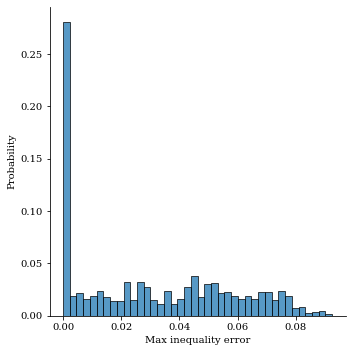

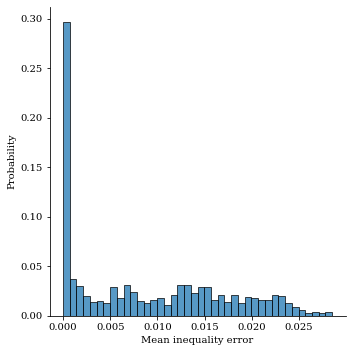

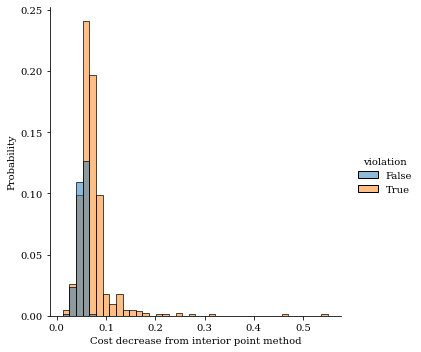

In [8]:
bins = 40

sns.displot(df, x="test/inequality/error_max", stat="probability", bins=bins)
plt.xlabel("Max inequality error")
save("error_max")

sns.displot(df, x="test/inequality/error_mean", stat="probability", bins=bins)
plt.xlabel("Mean inequality error")
save("error_mean")

# Cost improvement
df["test/cost/difference"] = df["acopf/cost"] - df["test/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df, x="test/cost/difference", hue="violation", stat="probability", bins=bins)
plt.xlabel("Cost decrease from interior point method")
save("costs")

# Visualizing Violations

In [9]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 0.09250700615196239
Idx 269


test/cost                                               1.34348
test/inequality/error_max                              0.092507
test/inequality/active_power/error_max                        0
test/inequality/reactive_power/error_max                      0
test/inequality/voltage_magnitude/error_max                   0
test/inequality/forward_rate/error_max                 0.092507
test/inequality/backward_rate/error_max               0.0784664
test/inequality/voltage_angle_difference/error_max            0
Name: 269, dtype: object

In [10]:
import opf.plot

dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double()

plots = opf.plot.plot_constraints(barrier, load, project=True)
for name in plots:
    save(name, fig=plots[name])

TypeError: plot_constraints() got an unexpected keyword argument 'project'

In [ ]:
forward_error = df.iloc[index]["test/inequality/forward_rate/error_max"]
backward_error = df.iloc[index]["test/inequality/backward_rate/error_max"]    

increase = 1 + torch.clamp((torch.maximum(Sf.abs(),St.abs()) - barrier.rate_a) / barrier.rate_a, min=0) \
    .squeeze().detach().numpy()
net = barrier.net_wrapper.net
original = net.line.copy()
barrier.net_wrapper.set_load_sparse(Sd.real.squeeze(), Sd.imag.squeeze())
net.line["max_i_ka"] *= increase
bus = torch.as_tensor(barrier.net_wrapper.optimal_ac()[0]).double().unsqueeze(0)
cost, constraints = barrier.optimal_power_flow(barrier.bus_from_polar(bus), load)
net.line = original

print("IPOPT Original Cost:", df.iloc[index]["acopf/cost"])
print("IPOPT Relaxed Cost:", cost.item())
print("GNN Cost", df.iloc[index]["test/cost"])

NameError: name 'Sf' is not defined